<h1 style='background:DarkSlateBlue;
          border-radius: 25px;
          padding: 20px;
          color:white;
          font-size:21px;
          border: 2px solid Lavender;
          font-family:cursive;
          text-align:center'><b>NLP LFQA Medical Dialogue – 📈 Analysis & Engineering 📊</b></h1>

<center>
    <img src='https://i.imgur.com/llC6JEk.jpg'>
</center>

Copyright [2022] [AI Engineer: [Ahmed](https://www.kaggle.com/dsxavier/)]

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# 📖<font size='5' color='DarkViolet'>Overview</font>

AI has been the dark horse for lots of applications and case studies in the medical industry, especially in consultation services.

Most of the AI Engineers in the medical industry start doing research related to diagnoses using CV, NLP, and RL Turbulence.

Today, we're going to dive deep to analyze a dataset I have been asked to do some analysis on which is [Diagnose me](https://www.kaggle.com/datasets/dsxavier/diagnoise-me).

# 📝<font size='5' color='DarkViolet'>Acknowledgments</font>

Diagnose me is an LFQA dataset of dialogues between patients and doctors based on factual conversations from [icliniq.com](icliniq.com) and [healthcaremagic.com](healthcaremagic.com) that aims to collect more than 257k of different questions and prescriptions for patients.

# 📝<font size='5' color='DarkViolet'>Proof of Work</font>

Here, I decided to analyze these dialogues and clean them for having them ready for Modeling. Unfortunately, we're not going to do any kinds of modelling here, all that we're going to do is analyse the dataset that we have by cleaning, removing the characters that represent a noise to the data, and adjusting the punctuation so it can help for having factual sentences.

I hope you like it!

# 📚<font size='5' color='DarkViolet'>Data Snippet</font>

<center><img width="500" src='https://i.imgur.com/XikBqRt.png'/></center>

# 🔖<font size='5' color='DarkViolet'>Dependencies</font>

# <font size='4' color='MediumSlateBlue'><b>(A) Install Dependencies</b></font>

In [1]:
%config Completer.use_jedi = False

In [2]:
!pip install -q feather-format
!pip install -q pandarallel==1.4.8
!pip install -q pyspellchecker
!pip install -q contractions
!pip install -q distilbert-punctuator
!pip install -q -U git+https://github.com/PrithivirajDamodaran/Gramformer.git
!python3 -m spacy download en

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
spacy 3.2.3 requires typing-extensions<4.0.0.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.1.1 which is incompatible.
featuretools 1.6.0 requires numpy>=1.21.0, but you have numpy 1.20.3 which is incompatible.
fairscale 0.4.5 requires torch>=1.8.0, but you have torch 1.7.1 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.2.0 requires spacy<3.3.0,>=3.2.0, but you have 

# <font size='4' color='MediumSlateBlue'><b>(B) Import Libraries</b></font>

In [3]:
import os
import time
import datetime
import warnings
warnings.filterwarnings('ignore')
import threading
import time, timeit
from typing import Text, Dict, List, Union, Tuple, Optional, Set
import re
from ast import literal_eval
from collections import defaultdict, Counter, OrderedDict

import pandas as pd
pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore')

from pandarallel import pandarallel # Panadas Asynchronous processing
pandarallel.initialize()

import numpy as np

import seaborn as sns
import matplotlib.pylab as plt

import torch
import nltk.data
import contractions
from spellchecker import SpellChecker
from gramformer import Gramformer

from dbpunctuator.inference import Inference, InferenceArguments
from dbpunctuator.utils import ALL_PUNCS, DEFAULT_ENGLISH_TAG_PUNCTUATOR_MAP
from dbpunctuator.utils.utils import register_logger

from tqdm.auto import trange, tqdm
from IPython.display import clear_output

%matplotlib inline

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


**Main Params for Matplotlib**

In [4]:
plt.rcParams['figure.figsize'] = [18, 15]
plt.style.use('fivethirtyeight')

**Main Params for Seaborn**

In [5]:
sns.set(style='darkgrid')
sns.set(rc={'figure.figsize':(18, 15)})
sns.set_theme(style="darkgrid")

**Tabular Data Configuration**

In [6]:
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

# <font size='4' color='MediumSlateBlue'><b>(C) Hardware Specifications</b></font>

In [7]:
# https://stackoverflow.com/a/20354129/14473118
import multiprocessing
pool = multiprocessing.Pool()
print(f'Number of workers for parallelism: {pool._processes}')

Number of workers for parallelism: 2


In [8]:
!nvidia-smi

Tue Apr  5 22:54:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---

# <font size='5' color='DarkSlateBlue'>1. Data Ingestion</font>

We're going to experiment with the data and see what kind of data do we have. We're going to extract a sample of this data since we're not going to work on +257k of dialogues, but we're going to extract 2k of utterances which represent 1k of dialogues between doctors & patients.

Our data ingestion will be from a type of **feather**. Lots of people don't know about **Feather** – it’s a data format for storing data frames (think **Pandas**). It’s designed around a simple premise — to push data frames in and out of memory as efficiently as possible. It was initially designed for fast communication between Python and R, but you’re not limited to this use case. *[Stop Using CSVs for Storage — This File Format Is 150 Times Faster
](https://towardsdatascience.com/stop-using-csvs-for-storage-this-file-format-is-150-times-faster-158bd322074e#:~:text=put%20simply%2C%20it%E2%80%99s%20a%20data%20format%20for%20storing%20data%20frames%20(think%20pandas).%20it%E2%80%99s%20designed%20around%20a%20simple%20premise%20%E2%80%94%20to%20push%20data%20frames%20in%20and%20out%20of%20memory%20as%20efficiently%20as%20possible.%20it%20was%20initially%20designed%20for%20fast%20communication%20between%20python%20and%20r%2C%20but%20you%E2%80%99re%20not%20limited%20to%20this%20use%20case.)*

![](https://miro.medium.com/max/764/1*SOhVXasSG16f3UKyeTtQ3A.png)

<center><a href="https://towardsdatascience.com/stop-using-csvs-for-storage-this-file-format-is-150-times-faster-158bd322074e#:~:text=image%203%20%E2%80%94%20csv%20vs.%20feather%20read%20time%20in%20seconds%20(csv%3A%203.85%3B%20feather%20(pandas)%3A%200.472%3B%20feather%3A%200.326)%20(image%20by%20author)">CSV vs. Feather read time in seconds (CSV: 3.85; Feather (Pandas): 0.472; Feather: 0.326) (image by author)</a></center>

In [9]:
df = pd.read_feather("../input/diagnoise-me/diagnose_en_dataset.feather")
df.head()

,id,Description,Doctor,Patient
0,0,Q. What does abutment of the nerve root mean?,Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online --> https://www.icliniq.com/ask-a-doctor-online/neurologist,"Hi doctor,I am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for annular bulging and tear?"
1,1,"Q. Every time I eat spicy food, I poop blood. Why?","Hello. I have gone through your information and test reports (attachment removed to protect patient identity). So, in view of that, there are a couple of things that I can opine upon: Hope that helps. For more information consult a general surgeon online --> https://icliniq.com./ask-a-doctor-online/general-surgeon","Hi doctor, I am a 26 year old male. I am 5 feet and 9 inches tall and weigh 255 pounds. When I eat spicy food, I poop blood. Sometimes when I have constipation as well, I poop a little bit of blood. I am really scared that I have colon cancer. I do have diarrhea often. I do not have a family history of colon cancer. I got blood tests done last night. Please find my reports attached."
2,2,Q. Will Nano-Leo give permanent solution for erection problem?,Hi. For further doubts consult a sexologist online --> https://www.icliniq.com/ask-a-doctor-online/sexologist,"Hello doctor, I am 48 years old. I am experiencing weak erection and difficulty in sustaining the same. This condition was observed 10 years back. Also, there is premature ejaculation. Other physical ailments that I have are, I am suffering from hypertension and taking Amlopres-L (Amlodipine and Lisinopril) for the last 10 years, high cholesterol and triglycerides. My cholesterol level is 225 and triglyceride is 200 for the last 12 years. I used to do frequent masturbation in early age. I do..."
3,3,Q. Will Kalarchikai cure multiple ovarian cysts in PCOD?,"Hello. I just read your query. See Kalarachi Kai choornam is helpful in amenorrhea. As far as small cysts are concerned they are unmatured eggs which failed to induce menstrual cycle previously, as a result, they got collected in the ovary and they will remain in the ovary. Now, you have got your periods you can start trying for conception. But I advise you to do it under the supervision of a nearby gynecologist because egg size is important while conception and that you can know by ovulatio...","Hello doctor, I have multiple small cysts in both ovaries (PCOS). Our family friend suggested me to consume Kalarchikai medicine, powdered mixed with pepper and honey to have it for one mandalam (48 days). I have completed nearly 44 days by consuming one small ball of the mixture every morning and before two weeks I got my periods. Then I had checked whether the cysts were dissolved by having an abdomen scan. But still, small multiple follicules have been seen in it with both ovaries enlarge..."
4,4,Q. I masturbate only by rubbing the tip of the penis. Is it a wrong way?,Hi. For further doubts consult a sexologist online -->https://www.icliniq.com/ask-a-doctor-online/sexologist,"Hi doctor, During masturbation I just rub the tip of the penis and not the entire penis. Is it a wrong way of doing? I do not get excited during sex and unable to ejaculate. Only, rubbing the tip of the penis gives me excitement. Also, two weeks ago, I have undergone circumcision as my foreskin did not retract. Before circumcision too, I have the same problem. Please help."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257469 entries, 0 to 257468
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           257469 non-null  int64 
 1   Description  257469 non-null  object
 2   Doctor       257469 non-null  object
 3   Patient      257469 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.9+ MB


Select 2k of the dataset

In [11]:
df = df[:2000]

In [12]:
df

,id,Description,Doctor,Patient
0,0,Q. What does abutment of the nerve root mean?,Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online --> https://www.icliniq.com/ask-a-doctor-online/neurologist,"Hi doctor,I am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for annular bulging and tear?"
1,1,"Q. Every time I eat spicy food, I poop blood. Why?","Hello. I have gone through your information and test reports (attachment removed to protect patient identity). So, in view of that, there are a couple of things that I can opine upon: Hope that helps. For more information consult a general surgeon online --> https://icliniq.com./ask-a-doctor-online/general-surgeon","Hi doctor, I am a 26 year old male. I am 5 feet and 9 inches tall and weigh 255 pounds. When I eat spicy food, I poop blood. Sometimes when I have constipation as well, I poop a little bit of blood. I am really scared that I have colon cancer. I do have diarrhea often. I do not have a family history of colon cancer. I got blood tests done last night. Please find my reports attached."
2,2,Q. Will Nano-Leo give permanent solution for erection problem?,Hi. For further doubts consult a sexologist online --> https://www.icliniq.com/ask-a-doctor-online/sexologist,"Hello doctor, I am 48 years old. I am experiencing weak erection and difficulty in sustaining the same. This condition was observed 10 years back. Also, there is premature ejaculation. Other physical ailments that I have are, I am suffering from hypertension and taking Amlopres-L (Amlodipine and Lisinopril) for the last 10 years, high cholesterol and triglycerides. My cholesterol level is 225 and triglyceride is 200 for the last 12 years. I used to do frequent masturbation in early age. I do..."
3,3,Q. Will Kalarchikai cure multiple ovarian cysts in PCOD?,"Hello. I just read your query. See Kalarachi Kai choornam is helpful in amenorrhea. As far as small cysts are concerned they are unmatured eggs which failed to induce menstrual cycle previously, as a result, they got collected in the ovary and they will remain in the ovary. Now, you have got your periods you can start trying for conception. But I advise you to do it under the supervision of a nearby gynecologist because egg size is important while conception and that you can know by ovulatio...","Hello doctor, I have multiple small cysts in both ovaries (PCOS). Our family friend suggested me to consume Kalarchikai medicine, powdered mixed with pepper and honey to have it for one mandalam (48 days). I have completed nearly 44 days by consuming one small ball of the mixture every morning and before two weeks I got my periods. Then I had checked whether the cysts were dissolved by having an abdomen scan. But still, small multiple follicules have been seen in it with both ovaries enlarge..."
4,4,Q. I masturbate only by rubbing the tip of the penis. Is it a wrong way?,Hi. For further doubts consult a sexologist online -->https://www.icliniq.com/ask-a-doctor-online/sexologist,"Hi doctor, During masturbation I just rub the tip of the penis and not the entire penis. Is it a wrong way of doing? I do not get excited during sex and unable to ejaculate. Only, rubbing the tip of the penis gives me excitement. Also, two weeks ago, I have undergone circumcision as my foreskin did not retract. Before circumcision too, I have the same problem. Please help."
...,...,...,...,...
1995,1995,Q. What does abutment of the nerve root mean?,Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online --> https://www.icliniq.com/ask-a-doctor-online/neurologist,"Hi doctor,I am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for annular bul

In [13]:
# Drop id column
df.drop(columns='id', inplace=True)

In [14]:
df.head()

,Description,Doctor,Patient
0,Q. What does abutment of the nerve root mean?,Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online --> https://www.icliniq.com/ask-a-doctor-online/neurologist,"Hi doctor,I am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for annular bulging and tear?"
1,"Q. Every time I eat spicy food, I poop blood. Why?","Hello. I have gone through your information and test reports (attachment removed to protect patient identity). So, in view of that, there are a couple of things that I can opine upon: Hope that helps. For more information consult a general surgeon online --> https://icliniq.com./ask-a-doctor-online/general-surgeon","Hi doctor, I am a 26 year old male. I am 5 feet and 9 inches tall and weigh 255 pounds. When I eat spicy food, I poop blood. Sometimes when I have constipation as well, I poop a little bit of blood. I am really scared that I have colon cancer. I do have diarrhea often. I do not have a family history of colon cancer. I got blood tests done last night. Please find my reports attached."
2,Q. Will Nano-Leo give permanent solution for erection problem?,Hi. For further doubts consult a sexologist online --> https://www.icliniq.com/ask-a-doctor-online/sexologist,"Hello doctor, I am 48 years old. I am experiencing weak erection and difficulty in sustaining the same. This condition was observed 10 years back. Also, there is premature ejaculation. Other physical ailments that I have are, I am suffering from hypertension and taking Amlopres-L (Amlodipine and Lisinopril) for the last 10 years, high cholesterol and triglycerides. My cholesterol level is 225 and triglyceride is 200 for the last 12 years. I used to do frequent masturbation in early age. I do..."
3,Q. Will Kalarchikai cure multiple ovarian cysts in PCOD?,"Hello. I just read your query. See Kalarachi Kai choornam is helpful in amenorrhea. As far as small cysts are concerned they are unmatured eggs which failed to induce menstrual cycle previously, as a result, they got collected in the ovary and they will remain in the ovary. Now, you have got your periods you can start trying for conception. But I advise you to do it under the supervision of a nearby gynecologist because egg size is important while conception and that you can know by ovulatio...","Hello doctor, I have multiple small cysts in both ovaries (PCOS). Our family friend suggested me to consume Kalarchikai medicine, powdered mixed with pepper and honey to have it for one mandalam (48 days). I have completed nearly 44 days by consuming one small ball of the mixture every morning and before two weeks I got my periods. Then I had checked whether the cysts were dissolved by having an abdomen scan. But still, small multiple follicules have been seen in it with both ovaries enlarge..."
4,Q. I masturbate only by rubbing the tip of the penis. Is it a wrong way?,Hi. For further doubts consult a sexologist online -->https://www.icliniq.com/ask-a-doctor-online/sexologist,"Hi doctor, During masturbation I just rub the tip of the penis and not the entire penis. Is it a wrong way of doing? I do not get excited during sex and unable to ejaculate. Only, rubbing the tip of the penis gives me excitement. Also, two weeks ago, I have undergone circumcision as my foreskin did not retract. Before circumcision too, I have the same problem. Please help."


There isn't much more to be done in **Data Ingestion**. Most of the work in Text is being done in **Data Analysis** & **Feature Engineering** – If you adjusted and transformed the data with the right formula, you can get high results. So, make sure you will spend most of your time in **Data Analysis** & **Feature Engineering**; if you didn't, you must understand that there's something wrong that will happen.


# <font size='5' color='DarkSlateBlue'>2. Data Analysis </font>

We're going to analyse the data, but we have to figure out the pattern that we're going to work according to it.

First, let's go and check the **data distribution** – it is one of the ways to know what is the length of our sentence and its distribution. In this way, we can know what is the average length of our sentences and what exactly we can do to fit them according to the model we want to use.

In [15]:
def plot_n_words(dataframe: pd.DataFrame,
                 column_name: Text,
                 n_bins: int,
                 color: Text,
                 axes: List[int],
                 condition: Text="before") -> None:

    axes.hist(dataframe.loc[:, column_name].str.split().map(lambda word: len(word)),
              bins=n_bins, color=color)
    axes.set_ylabel('words frequencey')
    axes.set_xlabel(f'No. words in {column_name}')
    axes.set_title(f'Plotting "{column_name}" {condition} FE', size=21)  

First, we're going to check the distribution of words in each utterance before starting doing our feature engineering. Exploring (a.k.a analysing) the data that you have allows you to know what exactly are you doing to do with it, how can you control it, and how you can gain the outcome that you're looking for.

In [16]:
colors = ['DarkSlateBlue', 'CornflowerBlue', 'DeepSkyBlue']
bins = [5, 30, 30]
df_copy = df.copy()

In [17]:
list(zip(df_copy.columns.values.tolist(),
         bins,
         colors))

[('Description', 5, 'DarkSlateBlue'),
 ('Doctor', 30, 'CornflowerBlue'),
 ('Patient', 30, 'DeepSkyBlue')]

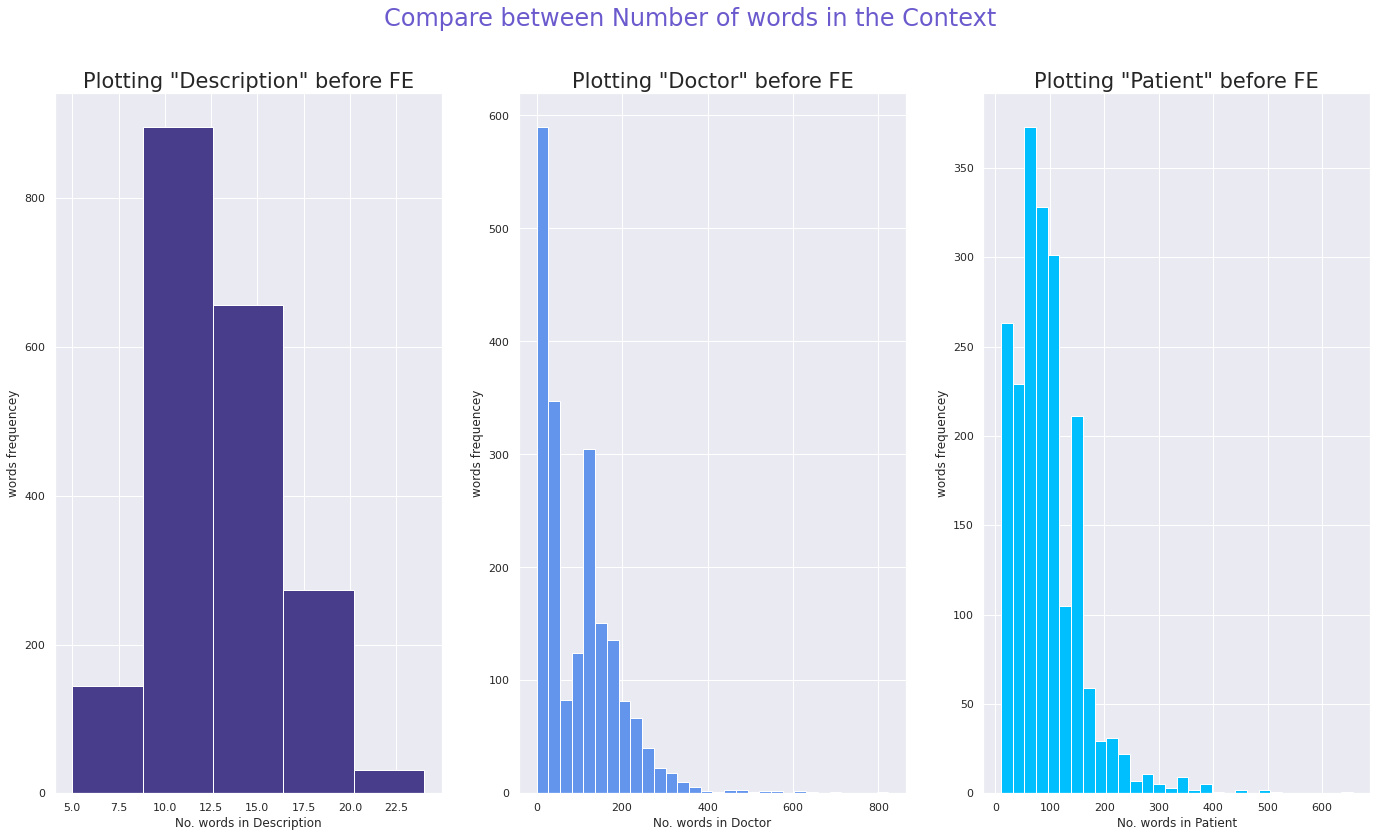

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(21, 12))
fig.suptitle('Compare between Number of words in the Context',
             size=24, color='SlateBlue')


for y, (feature, bin, color) in enumerate(zip(df_copy.columns.values.tolist(),
                                              bins,
                                              colors)):
    plot_n_words(df_copy,
                 column_name=feature,
                 n_bins=bin,
                 color=color,
                 axes=axes[y])
plt.show()

As we can see in the word distribution plot,  for each feature, we notice that  `Description` is well-balanced – unlike the `Docter` feature and the `patient` feature, each of them is skewed to the left, which means that most of the sentences are having words between [10, 250] words per sentence. It will be pretty beneficent to use the **LFQA** model for this data later, but let's stick with analysis for now!

Let's apply **Feature engineering**; first to clean the data and prepare it for modelling, and second to understand more about our data and how we can make it more beneficial for having better results.

# <font size='5' color='DarkSlateBlue'>3. Feature Engineering </font>


I used to use the `re` library for cleaning, processing, and engineering my data since it is the most efficient python built-in tool that you can master for having a professional career in NLP. I have step by step workflow I have done before in the tweets dataset, you can check that here! **[NLP Tweets – Deep Analysis & TFDistilBert-N-grams
](https://www.kaggle.com/code/dsxavier/nlp-tweets-deep-analysis-tfdistilbert-n-grams)**

# <font size='3' color='SteelBlue'><b>(A) Remove Markdown links</b></font>

In [19]:
def md_links(text: Text) -> Text:
    markdown_link=re.compile(r'\[.*?\]\(.*?\)')
    return markdown_link.sub(r'',text)

In [20]:
df['Description'] = df['Description'].parallel_apply(lambda sentence: md_links(sentence))
df['Doctor'] = df['Doctor'].parallel_apply(lambda sentence: md_links(sentence))
df['Patient'] = df['Patient'].parallel_apply(lambda sentence: md_links(sentence))

# <font size='3' color='SteelBlue'><b>(B) Remove Hyperlinks</b></font>

In [21]:
def scrape_links(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

Let's test it

In [22]:
link = df.loc[0,'Doctor']
link

'Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online --> https://www.icliniq.com/ask-a-doctor-online/neurologist  '

In [23]:
scrape_links(link)

'Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online -->   '

In [24]:
df['Description'] = df['Description'].parallel_apply(lambda sentence: scrape_links(sentence))
df['Doctor'] = df['Doctor'].parallel_apply(lambda sentence: scrape_links(sentence))
df['Patient'] = df['Patient'].parallel_apply(lambda sentence: scrape_links(sentence))

# <font size='3' color='SteelBlue'><b>(C) Dealing with Tags</b></font>

In [25]:
def remove_html_tags(text: Text) -> Text:
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [26]:
df['Description'] = df['Description'].parallel_apply(lambda sentence: remove_html_tags(sentence))
df['Doctor'] = df['Doctor'].parallel_apply(lambda sentence: remove_html_tags(sentence))
df['Patient'] = df['Patient'].parallel_apply(lambda sentence: remove_html_tags(sentence))

# <font size='3' color='SteelBlue'><b>(D) Char Words Converstion</b></font>

<center style='color:orange'><br><b>Hidden Cell contains all the abbreviated keywords</b><br></center>

In [27]:
CHAT_WORDS_STR = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [28]:
# First, we're going to convert this long string into set of words and its shortcut
chat_words_map_dict = {}
chat_shortcut_list = set()
for line in CHAT_WORDS_STR.split("\n"):
    if line != '':
        shortcut = line.split('=')[0] # split the line from `=` sign and select shortcut
        chat_words = line.split('=')[1]
        chat_shortcut_list.add(shortcut) # add the chat  shortcut to the set
        chat_words_map_dict[shortcut] = chat_words # add each chat_words corresponding to its shortcut

chat_words_map_dict

{'AFAIK': 'As Far As I Know',
 'AFK': 'Away From Keyboard',
 'ASAP': 'As Soon As Possible',
 'ATK': 'At The Keyboard',
 'ATM': 'At The Moment',
 'A3': 'Anytime, Anywhere, Anyplace',
 'BAK': 'Back At Keyboard',
 'BBL': 'Be Back Later',
 'BBS': 'Be Back Soon',
 'BFN': 'Bye For Now',
 'B4N': 'Bye For Now',
 'BRB': 'Be Right Back',
 'BRT': 'Be Right There',
 'BTW': 'By The Way',
 'B4': 'Before',
 'CU': 'See You',
 'CUL8R': 'See You Later',
 'CYA': 'See You',
 'FAQ': 'Frequently Asked Questions',
 'FC': 'Fingers Crossed',
 'FWIW': "For What It's Worth",
 'FYI': 'For Your Information',
 'GAL': 'Get A Life',
 'GG': 'Good Game',
 'GN': 'Good Night',
 'GMTA': 'Great Minds Think Alike',
 'GR8': 'Great!',
 'G9': 'Genius',
 'IC': 'I See',
 'ICQ': 'I Seek you (also a chat program)',
 'ILU': 'ILU: I Love You',
 'IMHO': 'In My Honest/Humble Opinion',
 'IMO': 'In My Opinion',
 'IOW': 'In Other Words',
 'IRL': 'In Real Life',
 'KISS': 'Keep It Simple, Stupid',
 'LDR': 'Long Distance Relationship',
 'LM

In [29]:
def chat_words_conversion(text: Text) -> Text:
    new_text = []
    for word in text.split():
        if word.upper() in chat_words_map_dict:
            new_text.append(chat_words_map_dict[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)

In [30]:
df['Description'] = df['Description'].parallel_apply(lambda sentence: chat_words_conversion(sentence))
df['Doctor'] = df['Doctor'].parallel_apply(lambda sentence: chat_words_conversion(sentence))
df['Patient'] = df['Patient'].parallel_apply(lambda sentence: chat_words_conversion(sentence))

# <font size='3' color='SteelBlue'><b>(E) English contractions</b></font>

**[What is a contraction?](https://www.grammarly.com/blog/contractions/)**

A contraction is a shortened form of a word (or group of words) that omits certain letters or sounds. In most contractions, an apostrophe represents the missing letters. The most common contractions are made up of verbs, auxiliaries, or modals attached to other words: `He would`=`He’d`. `I have`=`I’ve`. `They are`=`They’re`. `You cannot`=`You can’t`.

In [31]:
def en_contractions(text: Text) -> Text:
    return ' '.join([contractions.fix(word)
                     if word in contractions.contractions_dict else word
                     for word in text.split()])

In [32]:
example = "I've worked so hard today. I'm going to run to home!"

In [33]:
en_contractions(example)

'I have worked so hard today. I am going to run to home!'

In [34]:
df['Description'] = df['Description'].parallel_apply(lambda sentence: en_contractions(sentence))
df['Doctor'] = df['Doctor'].parallel_apply(lambda sentence: en_contractions(sentence))
df['Patient'] = df['Patient'].parallel_apply(lambda sentence: en_contractions(sentence))

# <font size='3' color='SteelBlue'><b>(F) Dealing with Special Characters</b></font>

We're going to scrape an example that will serve us after the next couple of processes 

In [35]:
example1 = df.loc[1997,'Doctor']
example1

'Hello. I have gone through your information and test reports (attachment removed to protect patient identity). So, in view of that, there are a couple of things that I can opine upon: Hope that helps. For more information consult a general surgeon online -->'

In [36]:
s_chars = '¥₽ÏïŰŬĎŸæ₿₪ÚŇÀèÅ”ĜåŽÖéříÿý€ŝĤ₹áŜŮÂ₴ûÌÇšŘúüëÓ₫ŠčÎŤÆÒœ₩öËäøÍťìĈôàĥÝ¢ç“žðÙÊĉŭÈŒÐÉÔĵùÁů„âÄűĴóêĝÞîØòď฿ČÜþňÛ'
PUNC = '+@«#_\-!$%%^&*¬()£<>?/\\|}\]\[{;\,~:\"\''

In [37]:
def special_char(text: Text) -> Text:
    # first, let's remove any unicode strings
    text = text.encode('ascii', 'ignore').decode()
    # remove printable bachslashes
    text = re.sub(r'[\t\s\n\r\b\a]', ' ', text)
    # Special letters
    text = re.sub(r'[{}]'.format(s_chars), '', text)
    # Punctuation [remove punctuation between spaces only which represent noises]
    text = re.sub(r'\s[{}]\s'.format(PUNC), ' ', text)
    # space at the start or the end of the context
    text = re.sub(r'(^\s)|(\s$)', '', text)
    # Single character
    text = re.sub(r'(\s[^iIaA]\s)', ' ', text)
    return text

In [38]:
df['Description'] = df['Description'].parallel_apply(lambda sentence: special_char(sentence))
df['Doctor'] = df['Doctor'].parallel_apply(lambda sentence: special_char(sentence))
df['Patient'] = df['Patient'].parallel_apply(lambda sentence: special_char(sentence))

# <font size='3' color='SteelBlue'><b>(G) Dealing with Special cases</b></font>

In [39]:
df['Description'] = df['Description'].str.replace("yr", 'year', regex=False)
df['Description'] = df['Description'].str.replace("...", ' ', regex=False)
df['Description'] = df['Description'].str.replace('-->', '', regex=False)
df['Description'] = df['Description'].str.replace('(attachment removed to protect patient identity)', '', regex=False)
df['Description'] = df['Description'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
df['Description'] = df['Description'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
df['Description'] = df['Description'].str.replace(r'(^\s)|(\s$)', '', regex=True)
df['Description'] = df['Description'].str.replace(r"(\si\s)", ' I ', regex=True)


df['Doctor'] = df['Doctor'].str.replace("yr", 'year', regex=False)
df['Doctor'] = df['Doctor'].str.replace("...", ' ', regex=False)
df['Doctor'] = df['Doctor'].str.replace('-->', '', regex=False)
df['Doctor'] = df['Doctor'].str.replace('(attachment removed to protect patient identity)', '', regex=False)
df['Doctor'] = df['Doctor'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
df['Doctor'] = df['Doctor'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
df['Doctor'] = df['Doctor'].str.replace(r'(^\s)|(\s$)', '', regex=True)
df['Doctor'] = df['Doctor'].str.replace(r"(\si\s)", ' I ', regex=True)

df['Patient'] = df['Patient'].str.replace("yr", 'year', regex=False)
df['Patient'] = df['Patient'].str.replace("...", ' ', regex=False)
df['Patient'] = df['Patient'].str.replace('-->', '', regex=False)
df['Patient'] = df['Patient'].str.replace('(attachment removed to protect patient identity)', '', regex=False)
df['Patient'] = df['Patient'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
df['Patient'] = df['Patient'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
df['Patient'] = df['Patient'].str.replace(r'(^\s)|(\s$)', '', regex=True)
df['Patient'] = df['Patient'].str.replace(r"(\si\s)", ' I ', regex=True)

Let's check our reserved example before and after finishing the last two phases

In [40]:
print(f"Original Text Before adjusting it:\n{example1}\n\nThis is after:\n{df.loc[1997,'Doctor']}")

Original Text Before adjusting it:
Hello. I have gone through your information and test reports (attachment removed to protect patient identity). So, in view of that, there are a couple of things that I can opine upon: Hope that helps. For more information consult a general surgeon online -->

This is after:
Hello. I have gone through your information and test reports So, in view of that, there are a couple of things that I can opine upon: Hope that helps. For more information consult a general surgeon online


# <font size='3' color='SteelBlue'><b>(H) Spell Correction</b></font>

In [41]:
spelling = SpellChecker(distance=1)
def misspelt_words_fn(dataframe: pd.DataFrame, column: Text) -> Set[Text]:
    misspelt_words = set()
    for text in dataframe[column].str.casefold():
        [misspelt_words.add(word) for word in spelling.unknown(text.split())]
    return misspelt_words

In [42]:
WORD = re.compile(r'\w+')
def reTokenize(sentence: Text) -> List[Text]:
    return WORD.findall(sentence.casefold())

In [43]:
PATTERN = re.compile(r"(.)\1{2,}", flags=re.IGNORECASE)
def reduce_lengthening(text: Text) -> Text:
    return PATTERN.sub(r"\1\1", text)

In [44]:
def spell_correction(text: Text, misspelt_list: List[Text]) -> Text:
    return ' '.join([spelling.correction(word)
                     if word in misspelt_list else word
                     for word in reTokenize(reduce_lengthening(text))])

First, we need to know how many misspelt words into the original text, and how many after we have done our pipeline.

**Before Applying the pipeline**

In [45]:
misspelt_desc_before = misspelt_words_fn(df_copy, 'Description')
misspelt_doctor_before = misspelt_words_fn(df_copy, 'Doctor')
misspelt_patient_before = misspelt_words_fn(df_copy, 'Patient')
print(f'Description misspelt: {len(misspelt_desc_before)}\nDoctor misspelt: {len(misspelt_doctor_before)}\nPatient misspelt: {len(misspelt_patient_before)}')

Description misspelt: 1426
Doctor misspelt: 8665
Patient misspelt: 7096


In [46]:
misspelt_desc = misspelt_words_fn(df, 'Description')
misspelt_doctor = misspelt_words_fn(df, 'Doctor')
misspelt_patient = misspelt_words_fn(df, 'Patient')

In [47]:
df['corrected_Description'] = df['Description'].parallel_apply(lambda sentence: spell_correction(sentence, misspelt_desc))
df['corrected_Doctor'] = df['Doctor'].parallel_apply(lambda sentence: spell_correction(sentence, misspelt_doctor))
df['corrected_Patient'] = df['Patient'].parallel_apply(lambda sentence: spell_correction(sentence, misspelt_patient))

***Reduce consecutive words in sentence***

In [48]:
def rm_duplicates(text: Text) -> Text:
    return re.sub(r'\b(\w+\s*)\1{1,}', '\\1', text)

In [49]:
df['corrected_Description'] = df['corrected_Description'].parallel_apply(lambda sentence: rm_duplicates(sentence))
df['corrected_Doctor'] = df['corrected_Doctor'].parallel_apply(lambda sentence: rm_duplicates(sentence))
df['corrected_Patient'] = df['corrected_Patient'].parallel_apply(lambda sentence: rm_duplicates(sentence))

**Check the number of misspelt words after Applying the spell correction**

In [50]:
misspelt_desc_after = misspelt_words_fn(df, 'corrected_Description')
misspelt_doctor_after = misspelt_words_fn(df, 'corrected_Doctor')
misspelt_patient_after = misspelt_words_fn(df, 'corrected_Patient')
print(f'Description misspelt: {len(misspelt_desc_after)}\nDoctor misspelt: {len(misspelt_doctor_after)}\nPatient misspelt: {len(misspelt_patient_after)}')

Description misspelt: 176
Doctor misspelt: 1354
Patient misspelt: 1091


***Adjustments after the Correction process***

In [51]:
df['corrected_Description'] = df['corrected_Description'].str.replace(r"(\si\s)", ' I ', regex=True)
df['corrected_Doctor'] = df['corrected_Doctor'].str.replace(r"(\si\s)", ' I ', regex=True)
df['corrected_Patient'] = df['corrected_Patient'].str.replace(r"(\si\s)", ' I ', regex=True)

df['corrected_Description'] = df['corrected_Description'].str.replace(r"(q\s)", '', regex=True)
df['corrected_Description'] = df['corrected_Description'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
df['corrected_Doctor'] = df['corrected_Doctor'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
df['corrected_Patient'] = df['corrected_Patient'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)

# <font size='3' color='SteelBlue'><b>(I) Restore Punctuation</b></font>

Punctuations are important for having semantic context when you are applying NLP – especially if you are creating generative models. This will allow you to create a model that has the same capability of writing as human writing. Therefore, we need a **punctuator** model which allows us to restore the punctuation in our sentences. Hence, we're going to use a model called **Punctuator**.

In [52]:
args = InferenceArguments(
              model_name_or_path="Qishuai/distilbert_punctuator_en",
              tokenizer_name="Qishuai/distilbert_punctuator_en",
              tag2punctuator=DEFAULT_ENGLISH_TAG_PUNCTUATOR_MAP,
)
inference = Inference(inference_args=args, verbose=False)

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]

Let's give an example of how it works..

### (A) Streaming

In [53]:
df['corrected_Doctor'].values.tolist()[3:4]

['hello I just read your query see kalarachi kai choornam is helpful in amenorrhea as far as small cysts are concerned they are unmatured eggs which failed to induce menstrual cycle previously as a result they got collected in the ovary and they will remain in the ovary now you have got your periods you can start trying for conception but I advise you to do it under the supervision of a nearby gynecologist because egg size is important while conception and that you can know by ovulation study ovulation study is performed under the supervision of a gynecologist for gall stones surgical intervention is required generally medicine is not of much help']

In [54]:
inference.punctuation(df['corrected_Doctor'].values.tolist()[3:4])[0]

['Hello. I just read your query. See, kalarachi kai choornam is helpful in amenorrhea. As far as small cysts are concerned, they are unmatured eggs, which failed to induce menstrual cycle previously. As a result, they got collected in the ovary and they will remain in the ovary. Now you have got your periods. You can start trying for conception, but I advise you to do it under the supervision of a nearby gynecologist, because egg size is important while conception, and that you can know by ovulation study, ovulation study is performed under the supervision of a gynecologist for gall stones. Surgical intervention is required generally, medicine is not of much help.']

### (B) Batch Mode

In [55]:
df['corrected_Doctor'].values.tolist()[:5]

['hi I have gone through your query with diligence and would like you to know that I am here to help you for further information consult a neurologist online',
 'hello I have gone through your information and test reports so in view of that there are a couple of things that I can opine upon hope that helps for more information consult a general surgeon online',
 'hi for further doubts consult a sexologist online',
 'hello I just read your query see kalarachi kai choornam is helpful in amenorrhea as far as small cysts are concerned they are unmatured eggs which failed to induce menstrual cycle previously as a result they got collected in the ovary and they will remain in the ovary now you have got your periods you can start trying for conception but I advise you to do it under the supervision of a nearby gynecologist because egg size is important while conception and that you can know by ovulation study ovulation study is performed under the supervision of a gynecologist for gall stones

In [56]:
def punct_restoration(list_of_text: List[Text], name: Text) -> List[Text]:
    list_of_texts = []
    for text in tqdm(list_of_text, desc=f"Auto Punctuation for {name}"):
        list_of_texts.append(
            inference.punctuation([text])[0][0]
        )
    return list_of_texts

In [57]:
punct_restoration(df['corrected_Doctor'].values.tolist()[:5], 'demo')

Auto Punctuation for demo:   0%|          | 0/5 [00:00<?, ?it/s]

['Hi. I have gone through your query with diligence and would like you to know that I am here to help you for further information consult a neurologist online.',
 'Hello, I have gone through your information and test reports. So in view of that, there are a couple of things that I can opine upon hope that helps for more information consult a general surgeon online.',
 'Hi for further doubts consult a sexologist online.',
 'Hello. I just read your query. See, kalarachi kai choornam is helpful in amenorrhea. As far as small cysts are concerned, they are unmatured eggs, which failed to induce menstrual cycle previously. As a result, they got collected in the ovary and they will remain in the ovary. Now you have got your periods. You can start trying for conception, but I advise you to do it under the supervision of a nearby gynecologist, because egg size is important while conception, and that you can know by ovulation study, ovulation study is performed under the supervision of a gynecol

What I like about this library is that it doesn't restore the punctuation only, but it also capitalizes the letters at the beginning of sentence and has a high sense of the sentences.

**Apply on our dataset**

In [58]:
df['punc_corrected_Description'] = punct_restoration(df['corrected_Description'].values.tolist(), "Description")
df['punc_corrected_Doctor'] = punct_restoration(df['corrected_Doctor'].values.tolist(), 'Doctor')
df['punc_corrected_Patient'] = punct_restoration(df['corrected_Patient'].values.tolist(), "Patient")

Auto Punctuation for Description:   0%|          | 0/2000 [00:00<?, ?it/s]

Auto Punctuation for Doctor:   0%|          | 0/2000 [00:00<?, ?it/s]

Auto Punctuation for Patient:   0%|          | 0/2000 [00:00<?, ?it/s]

# <font size='3' color='SteelBlue'><b>(J) Grammerly Correction</b></font>

We're going to use a library called **Gramformer**

> Human and machine generated text often suffer from grammatical and/or typographical errors. It can be spelling, punctuation, grammatical or word choice errors. Gramformer is a library that exposes 3 seperate interfaces to a family of algorithms to detect, highlight and correct grammar errors. To make sure the corrections and highlights recommended are of high quality, it comes with a quality estimator. You can use Gramformer in one or more areas mentioned under the "use-cases" section below or any other usecase as you see fit. Gramformer stands on the shoulders of giants, it combines some of the top notch researches in grammar correction. Note: It works at sentence levels and has been trained on 64 length sentences, so not (yet) suitable for long prose or paragraphs (stay tuned for upcoming releases). ref: *[Gramformer](https://github.com/PrithivirajDamodaran/Gramformer)*

In [59]:
# Controlling random samples
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [60]:
set_seed(1212)
gf = Gramformer(models = 1, use_gpu=True) # 1=corrector, 2=detector

Downloading:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

[Gramformer] Grammar error correct/highlight model loaded..


In [61]:
def grammely_correction(list_text: List[Text], name: Text) -> List[Text]:
    list_of_correction = []
    for text in tqdm(list_text, desc=f'Grammerly Correction for {name}'):
        list_of_correction.append([correct for correct in gf.correct(text, max_candidates=1)][0])
    return list_of_correction

Let's hit an example

In [62]:
example2 = 'I was eating, then my uncle are leaving'

In [63]:
gf.correct(example2)

{'I was eating, then my uncle was leaving.'}

Let's try **Long Form Sentence**

In [64]:
long_sentence = """
Hello doctor, I am 48 years old. I am experiencing weak erection and difficulty in sustaining
the same. This condition was observed 10 years back. Also, there is premature ejaculation.
Other physical ailments that I have are, I am suffering from hypertension and
taking Amlopres-L (Amlodipine and Lisinopril) for the last 10 years,
high cholesterol and triglycerides. My cholesterol level is 225 and
triglyceride is 200 for the last 12 years. I used to do frequent masturbation in early age.
I do have erection during morning hours many times, particularly after sound sleep or
if I had long walk previous day. I am having Sildenafil 25 mg or mg Cialis,
which is effective enough. But, I wish to get rid of tablet support and live natural way.
I consulted urologist today and he prescribed me Nano-Leo capsules and Modula mg for 10 days.
I wish to have your second opinion on this. Please guide.
"""

In [65]:
# Length of the long sequence
len(long_sentence.split())

154

In [66]:
gram_scent = gf.correct(long_sentence)
gram_scent

{'Hello doctor, I am 48 years old. I am experiencing weak erection and difficulty in sustaining the same. This condition was observed 10 years back. Also, there is premature ejaculation. Other physical ailments that I have are, I am suffering from hypertension and taking Amlopres'}

In [67]:
len(list(gram_scent)[0].split())

45

We can see here that the sentences are cut into a certain size of words. in our example here, we can see that a sentence that has a length of **154** words is converted to  **45** words. This is quite bad! Lots of information has been removed, this can affect the dataset, badly. So, what can we do? The best this is to start splitting the long-form paragraph into utterances, therefore we will be able to have a small number of words sent to the **Gramformer corrector**, and also we will not lose our long-form text. To do that, we can use **NLTK**.

In [68]:
# Ref: https://stackoverflow.com/a/4576110/14473118
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
list_of_sentences = tokenizer.tokenize(long_sentence)
list_of_sentences

['\nHello doctor, I am 48 years old.',
 'I am experiencing weak erection and difficulty in sustaining\nthe same.',
 'This condition was observed 10 years back.',
 'Also, there is premature ejaculation.',
 'Other physical ailments that I have are, I am suffering from hypertension and\ntaking Amlopres-L (Amlodipine and Lisinopril) for the last 10 years,\nhigh cholesterol and triglycerides.',
 'My cholesterol level is 225 and\ntriglyceride is 200 for the last 12 years.',
 'I used to do frequent masturbation in early age.',
 'I do have erection during morning hours many times, particularly after sound sleep or\nif I had long walk previous day.',
 'I am having Sildenafil 25 mg or mg Cialis,\nwhich is effective enough.',
 'But, I wish to get rid of tablet support and live natural way.',
 'I consulted urologist today and he prescribed me Nano-Leo capsules and Modula mg for 10 days.',
 'I wish to have your second opinion on this.',
 'Please guide.']

Now, let's check the longest sentence inside this list.

In [69]:
print(f"""List of sentences sizes: {list(map(len, [text.split() for text in list_of_sentences]))}
max words per sentence is: {max(map(len, [text.split() for text in list_of_sentences]))}""")

List of sentences sizes: [7, 11, 7, 5, 27, 14, 9, 21, 13, 13, 16, 9, 2]
max words per sentence is: 27


**Okey, that's interesting...**

Let's adjust our function then...

In [70]:
def grammely_correction(list_text: List[Text], name: Text) -> List[Text]:
    list_of_correction = []
    for text in tqdm(list_text, desc=f'Grammerly Correction for {name}'):
        if len(text.split()) < 50:
            list_of_correction.append(list(gf.correct(text, max_candidates=1))[0])
        else:
            list_of_correction.append(" ".join([list(gf.correct(sentence, max_candidates=1))[0]
                                                for sentence in tokenizer.tokenize(text)]))
    return list_of_correction

In [71]:
df['gram_corrected_Description'] = grammely_correction(df['punc_corrected_Description'].values.tolist(), "Description")
df['gram_corrected_Doctor'] = grammely_correction(df['punc_corrected_Doctor'].values.tolist(), 'Doctor')
df['gram_corrected_Patient'] = grammely_correction(df['punc_corrected_Patient'].values.tolist(), "Patient")

Grammerly Correction for Description:   0%|          | 0/2000 [00:00<?, ?it/s]

Grammerly Correction for Doctor:   0%|          | 0/2000 [00:00<?, ?it/s]

Grammerly Correction for Patient:   0%|          | 0/2000 [00:00<?, ?it/s]

**hawooo!!! Finally**

In [72]:
df

,Description,Doctor,Patient,corrected_Description,corrected_Doctor,corrected_Patient,punc_corrected_Description,punc_corrected_Doctor,punc_corrected_Patient,gram_corrected_Description,gram_corrected_Doctor,gram_corrected_Patient
0,Q. What does abutment of the nerve root mean?,Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online,"Hi doctor,I am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for annular bulging and tear?",what does abutment of the nerve root mean,hi I have gone through your query with diligence and would like you to know that I am here to help you for further information consult a neurologist online,hi doctor I am just wondering what is abutting and abutment of the nerve root means in a back issue please explain what treatment is required for annular bulging and tear,What does abutment of the nerve root mean?,Hi. I have gone through your query with diligence and would like you to know that I am here to help you for further information consult a neurologist online.,"Hi, doctor. I am just wondering what is abutting and abutment of the nerve root means in a back issue, please explain what treatment is required for annular bulging and tear.",What does abutment of the nerve root mean?,"Hi. I have gone through your query with diligence and would like you to know that I am here to help you for further information, consult a neurologist online.","Hi, doctor. I am just wondering what abutting and abutment of the nerve root means in a back issue, please explain what treatment is required for annular bulging and tear."
1,"Q. Every time I eat spicy food, I poop blood. Why?","Hello. I have gone through your information and test reports So, in view of that, there are a couple of things that I can opine upon: Hope that helps. For more information consult a general surgeon online","Hi doctor, I am a 26 year old male. I am feet and inches tall and weigh 255 pounds. When I eat spicy food, I poop blood. Sometimes when I have constipation as well, I poop a little bit of blood. I am really scared that I have colon cancer. I do have diarrhea often. I do not have a family history of colon cancer. I got blood tests done last night. Please find my reports attached.",every time I eat spicy food I poop blood why,hello I have gone through your information and test reports so in view of that there are a couple of things that I can opine upon hope that helps for more information consult a general surgeon online,hi doctor I am a 26 year old male I am feet and inches tall and weigh 255 pounds when I eat spicy food I poop blood sometimes when I have constipation as well I poop a little bit of blood I am really scared that I have colon cancer I do have diarrhea often I do not have a family history of colon cancer I got blood tests done last night please find my reports attached,"Every time I eat spicy food, I poop blood. Why","Hello, I have gone through your information and test reports. So in view of that, there are a couple of things that I can opine upon hope that helps for more information consult a general surgeon online.","Hi, doctor. I am a 26 year old male. I am feet and inches tall and weigh 255 pounds. When I eat spicy food, I poop blood. Sometimes when I have constipation as well. I poop a little bit of blood. I am really scared that I have colon cancer. I do have diarrhea. Often, I do not have a family history of colon cancer. I got blood tests done last night. Please find my reports attached.","Every time I eat spicy food, I poop. Why?","Hello, I have been through your information and test reports. So in view of that, there are a couple of things that I can opine upon that hope that helps for more information consult a general surgeon online.","Hi, Doctor. I am a 26 year old male. I am a foot and inch tall and weigh 255 pounds. When I eat spicy food

Now, let's remove any other columns and bring the original columns' name

In [73]:
df.drop(columns=["Description",
                 "Doctor",
                 "Patient",
                 "corrected_Description",
                 "corrected_Doctor",
                 "corrected_Patient",
                 "punc_corrected_Description",
                 "punc_corrected_Doctor",
                 "punc_corrected_Patient"], inplace=True)

In [74]:
df.rename(columns={"gram_corrected_Description": "Description",
                   "gram_corrected_Doctor": "Doctor",
                   "gram_corrected_Patient": "Patient"}, inplace=True)

In [75]:
df

,Description,Doctor,Patient
0,What does abutment of the nerve root mean?,"Hi. I have gone through your query with diligence and would like you to know that I am here to help you for further information, consult a neurologist online.","Hi, doctor. I am just wondering what abutting and abutment of the nerve root means in a back issue, please explain what treatment is required for annular bulging and tear."
1,"Every time I eat spicy food, I poop. Why?","Hello, I have been through your information and test reports. So in view of that, there are a couple of things that I can opine upon that hope that helps for more information consult a general surgeon online.","Hi, Doctor. I am a 26 year old male. I am a foot and inch tall and weigh 255 pounds. When I eat spicy food, I poop from the blood. Sometimes I get constipation as well. I poop a little bit of blood. I am really scared that I have colon cancer. I do have diarrhea. Often, I do not have a family history of colon cancer. I got my blood tests done last night. Please see my report attached."
2,Will nano leos provide permanent solutions for erection problem?,For further questions consult a sexologist online.,"Hello, Dr. I am 48 years old. I am experiencing weak erection and difficulty in maintaining the same. This condition was observed 10 years back. Also, there is premature ejaculation. Other physical ailments that I have include I am suffering from hypertension, amlodipine and lisinopril for the last 10 years, high cholesterol and triglycerides. My cholesterol level is 25, and triglycerides are 200 for the last 12 years. I used to do frequent masturbation at an early age. I do have seizures du..."
3,Will Kalarchikai cure multiple ovarian cysts in pod?,"Hello! I just read your query. See, kalarachi kai choornam is helpful in amenorrhea. As far as small cysts are concerned, they are unmature eggs, which failed to induce a menstrual cycle previously. As a result, they got collected in the ovary and they remain in the ovary. Now you have got your period. You can start trying for conception, but I advise you to do it under the supervision of a nearby gynaecologist, because egg size is important while conception, and as you can know by ovulation...","Hello, doctor. I have multiple small cysts in both ovaries, cos, our family friend suggested I consume kalarchikai medicine, powdered mixed with pepper and honey to keep it from happening. For one mandala, 48 days. I have completed nearly two days by consuming one small ball of the mixture every morning, and before two weeks, I was beginning my periods. Then I checked whether the cysts were dissolved by having an abdominal scan. But still small. Multiple follicles have been seen in it with b..."
4,I masturbate by rubbing the tip of the penis. Is it the wrong way?,If you have further doubts consult a sexologist online.,"Hi, Doctor. When masturbation, I just rub on the tip of the penis and not the entire penis. Is it the wrong way to work? I do not get excited when sex and am unable to ejaculate. Only rubbing the tip of the penis gives me excitement. Also, two weeks ago, I underwent circumcision as my foreskin did not retract before circumcision too. I have the same problem. Please help."
...,...,...,...
1995,What does abutment of the nerve root mean?,"Hi, I have gone through your query with diligence and would like you to know that I am here to help you, for further information, consult a neurologist online.","Hi, Doctor. I am just wondering what abutting and abutment of the nerve root means in a back issue, please explain what treatment is required for annular bulging and tear."
1996,Will nano leo provide permanent solution to erection problem?,For further doubts consult a sexologist online.,"Hello, doctor. I am 48 years old. I am experiencing weak erection and difficulty in sustaining the same. This condition was observed 10 years ago. Also, there is premature ejaculation. Other physical ailments that I have include: I am suffering from

In [76]:
df.isna().value_counts()

Description  Doctor  Patient
False        False   False      2000
dtype: int64

# <font size='5' color='DarkSlateBlue'>2. Continue Data Analysis </font>

Now, let's check the comparison between the original sampled dataset and our cleaned, processed, engineered dataset.

# <font size='3' color='SteelBlue'><b>(A) Check the word Distribution Differences</b></font>

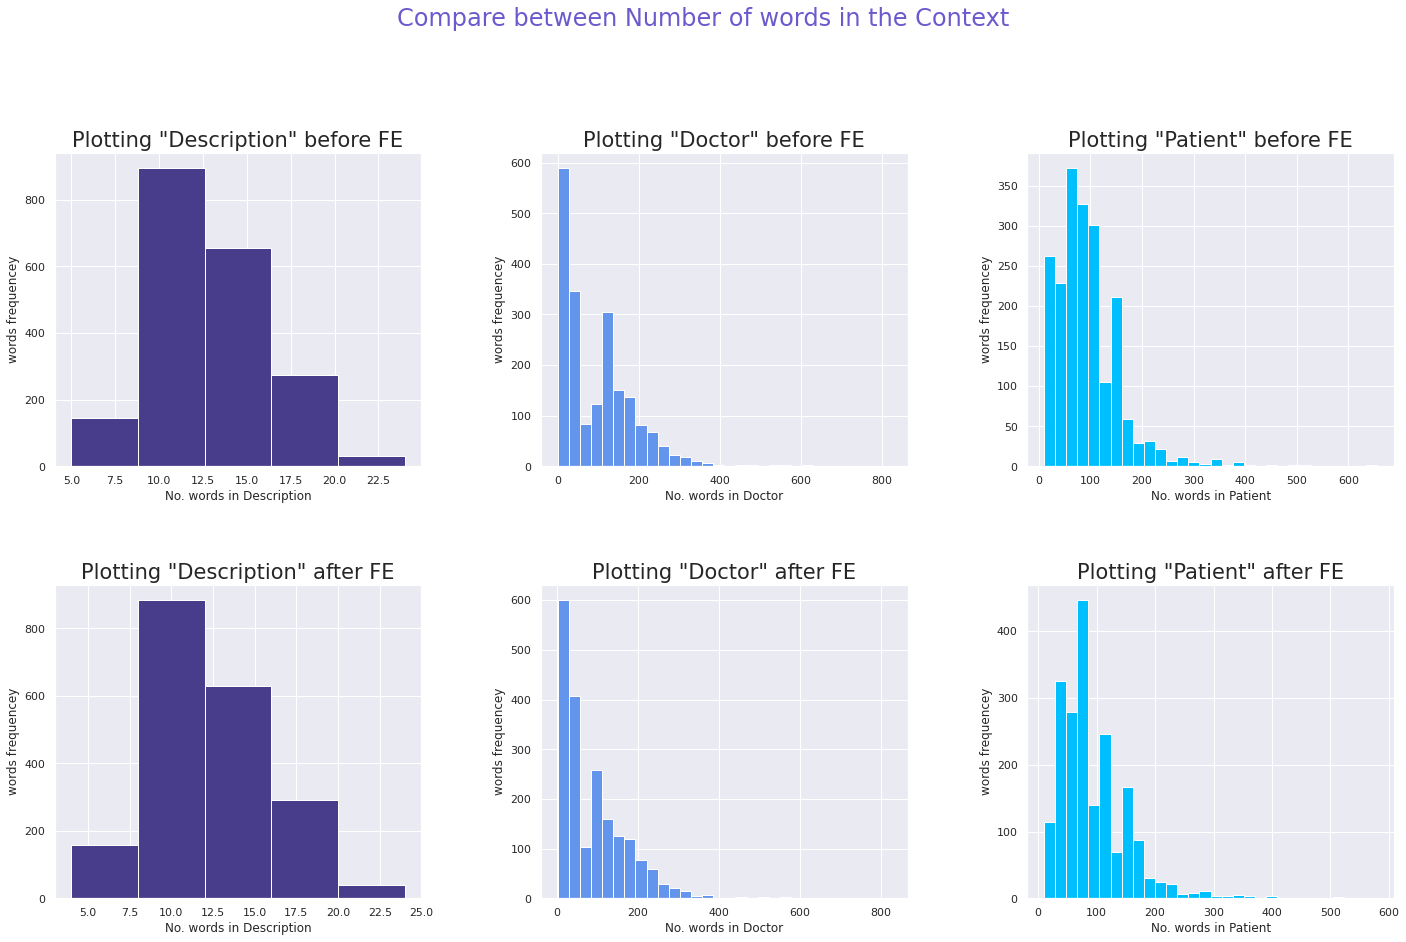

In [77]:
fig, axes = plt.subplots(2, 3, figsize=(21, 14))
fig.suptitle('Compare between Number of words in the Context',
             size=24, color='SlateBlue')


for y, (feature, bin, color) in enumerate(zip(df.columns.values.tolist(),
                                              bins,
                                              colors)):
    # df_copy
    plot_n_words(df_copy,
                 column_name=feature,
                 n_bins=bin,
                 color=color,
                 axes=axes[0, y],
                 condition='before')
    # df
    plot_n_words(df,
                 column_name=feature,
                 n_bins=bin,
                 color=color,
                 axes=axes[1, y],
                 condition='after')
fig.tight_layout(pad=5.0)
plt.show()

# <font size='3' color='SteelBlue'><b>(B) Plotting Most Frequent Words</b></font>

Let's try to use a concept called **[N-grams](https://towardsdatascience.com/understanding-word-n-grams-and-n-gram-probability-in-natural-language-processing-9d9eef0fa058)**:
> *Using these n-grams and the probabilities of the occurrences of certain words in certain sequences could improve the predictions of auto completion systems. Similarly, we use can NLP and n-grams to train voice-based personal assistant bots. For example, using a 3-gram or trigram training model, a bot will be able to understand the difference between sentences such as “what’s the temperature?” and “set the temperature.”*

In [78]:
# Define the N-grams function
def gen_ngrams_fn(text: Text, n_grams: int=2)-> Text:
    # Split all the words and insert them into list in sequence;
    ## First, ensure that the word is not a `space`.
    ## Second, the word you're going to insert not inside the stopwords.
    word_list = [word for word in text.lower().split() 
                 if word != ' ']
    
    # capture N-sequence of words togther
    ngrams = zip(*[word_list[i:] for i in range(n_grams)])
    
    # Convert the context from list to str
    return [' '.join(ngram) for ngram in ngrams]

In [79]:
def ngrams_fn(dataframe: pd.DataFrame,
              column: Text,
              n_grams:int=2,
              sort: Optional[bool]=True) -> pd.DataFrame:
    
    n_grams_dict = defaultdict(int)
    
    for text in dataframe[column]:
        for context in gen_ngrams_fn(text, n_grams):
            # Apply N-grams probability of the occurrence of certain N-words in certain Sequence
            # in form of most occurrence
            n_grams_dict[context] +=1
    
    # Create dataframe with number of occurrences is the id we sort the data with.
    n_grams_dataframe = pd.DataFrame(n_grams_dict.items())
    n_grams_dataframe.columns = ['N-grams', 'occurs']

    if sort:
        n_grams_dataframe.sort_values(by='occurs', ascending=False, inplace=True)
    
    return n_grams_dataframe


def plot_ngrams(dataframe: pd.DataFrame,
                axes,
                number_of_samples: int=20) -> None:
    # Plot the dataset
    sns.barplot(x=dataframe.iloc[:,1][:number_of_samples],
                y=dataframe.iloc[:,0][:number_of_samples], ax=axes)
    axes.set_yticks(range(number_of_samples),
                    dataframe.iloc[:,0][:number_of_samples], size=14)

<p style='background:MediumSlateBlue;
          border-radius: 25px;
          padding: 20px;
          color:white;
          font-size:21px;
          font-family:cursive;
          border: 2px solid Lavender;
          text-align:center'><b>Top 20 Most Frequent Bi-grams</b></p>

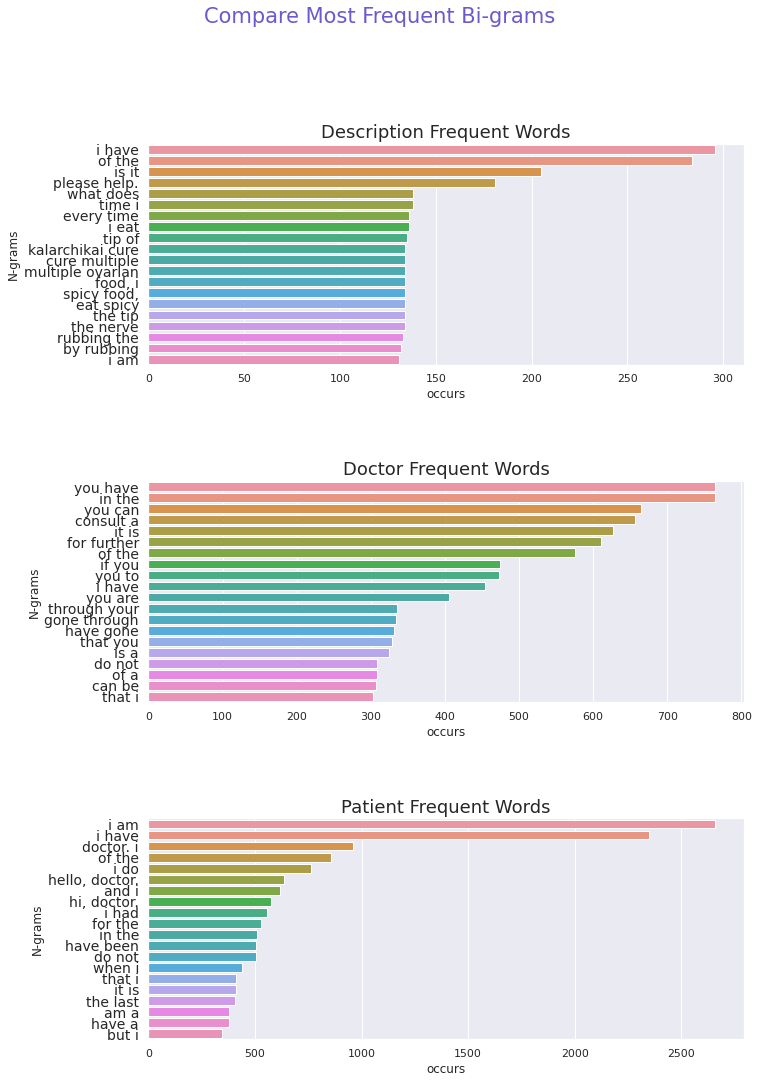

In [80]:
fig, axes = plt.subplots(3, 1, figsize=(12, 16))

fig.suptitle('Compare Most Frequent Bi-grams',
             size=21, color='SlateBlue')
axes[0].set_title('Description Frequent Words', size=18)
axes[1].set_title('Doctor Frequent Words', size=18)
axes[2].set_title('Patient Frequent Words', size=18)

plot_ngrams(ngrams_fn(df, 'Description'), axes=axes[0])
plot_ngrams(ngrams_fn(df, 'Doctor'), axes=axes[1])
plot_ngrams(ngrams_fn(df, 'Patient'), axes=axes[2])

fig.tight_layout(pad=5.0)
plt.show()

**Top 20 of most *Bi-grams* in `Description`**

In [81]:
ngrams_fn(df, 'Description').reset_index(drop=True)\
.head(20).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,i have,296
1,of the,284
2,is it,205
3,please help.,181
4,what does,138
5,time i,138
6,every time,136
7,i eat,136
8,tip of,135
9,kalarchikai cure,134


**Top 20 of most *Bi-grams* in `Doctor`**

In [82]:
ngrams_fn(df, 'Doctor').reset_index(drop=True)\
.head(20).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,you have,765
1,in the,764
2,you can,665
3,consult a,656
4,it is,627
5,for further,611
6,of the,576
7,if you,474
8,you to,473
9,i have,454


**Top 20 of most *Bi-grams* in `Description`**

In [83]:
ngrams_fn(df, 'Patient').reset_index(drop=True)\
.head(20).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,i am,2660
1,i have,2350
2,doctor. i,962
3,of the,856
4,i do,764
5,"hello, doctor.",638
6,and i,615
7,"hi, doctor.",575
8,i had,556
9,for the,529


<p style='background:MediumSlateBlue;
          border-radius: 25px;
          padding: 20px;
          color:white;
          font-size:21px;
          border: 2px solid Lavender;
          font-family:cursive;
          text-align:center'><b>Top 20 Most Frequent Tri-grams</b></p>

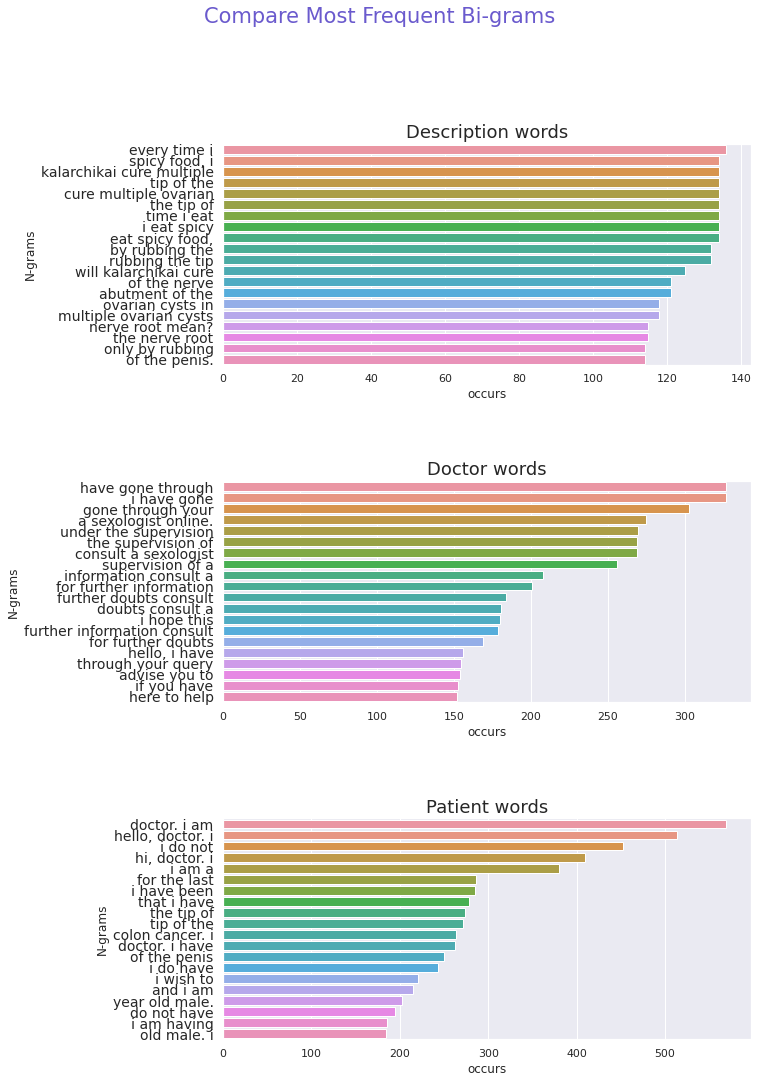

In [84]:
fig, axes = plt.subplots(3, 1, figsize=(12, 16))

fig.suptitle('Compare Most Frequent Bi-grams',
             size=21, color='SlateBlue')
axes[0].set_title('Description words', size=18)
axes[1].set_title('Doctor words', size=18)
axes[2].set_title('Patient words', size=18)

plot_ngrams(ngrams_fn(df, 'Description', n_grams=3), axes=axes[0])
plot_ngrams(ngrams_fn(df, 'Doctor', n_grams=3), axes=axes[1])
plot_ngrams(ngrams_fn(df, 'Patient', n_grams=3), axes=axes[2])

fig.tight_layout(pad=5.0)
plt.show()

**Top 20 of most *Tri-grams* in `Description`**

In [85]:
ngrams_fn(df, 'Description', n_grams=3).reset_index(drop=True)\
.head(20).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,every time i,136
1,"spicy food, i",134
2,kalarchikai cure multiple,134
3,tip of the,134
4,cure multiple ovarian,134
5,the tip of,134
6,time i eat,134
7,i eat spicy,134
8,"eat spicy food,",134
9,by rubbing the,132


**Top 20 of most *Tri-grams* in `Doctor`**

In [86]:
ngrams_fn(df, 'Doctor', n_grams=3).reset_index(drop=True)\
.head(20).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,have gone through,327
1,i have gone,327
2,gone through your,303
3,a sexologist online.,275
4,under the supervision,270
5,the supervision of,269
6,consult a sexologist,269
7,supervision of a,256
8,information consult a,208
9,for further information,201


**Top 20 of most *Tri-grams* in `Description`**

In [87]:
ngrams_fn(df, 'Patient', n_grams=3).reset_index(drop=True)\
.head(20).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,doctor. i am,569
1,"hello, doctor. i",514
2,i do not,452
3,"hi, doctor. i",409
4,i am a,380
5,for the last,286
6,i have been,285
7,that i have,278
8,the tip of,274
9,tip of the,271


<p style='background:MediumSlateBlue;
          border-radius: 25px;
          padding: 20px;
          color:white;
          font-size:21px;
          border: 2px solid Lavender;
          font-family:cursive;
          text-align:center'><b>Dataset Final Shape</b></p>

In [88]:
df

,Description,Doctor,Patient
0,What does abutment of the nerve root mean?,"Hi. I have gone through your query with diligence and would like you to know that I am here to help you for further information, consult a neurologist online.","Hi, doctor. I am just wondering what abutting and abutment of the nerve root means in a back issue, please explain what treatment is required for annular bulging and tear."
1,"Every time I eat spicy food, I poop. Why?","Hello, I have been through your information and test reports. So in view of that, there are a couple of things that I can opine upon that hope that helps for more information consult a general surgeon online.","Hi, Doctor. I am a 26 year old male. I am a foot and inch tall and weigh 255 pounds. When I eat spicy food, I poop from the blood. Sometimes I get constipation as well. I poop a little bit of blood. I am really scared that I have colon cancer. I do have diarrhea. Often, I do not have a family history of colon cancer. I got my blood tests done last night. Please see my report attached."
2,Will nano leos provide permanent solutions for erection problem?,For further questions consult a sexologist online.,"Hello, Dr. I am 48 years old. I am experiencing weak erection and difficulty in maintaining the same. This condition was observed 10 years back. Also, there is premature ejaculation. Other physical ailments that I have include I am suffering from hypertension, amlodipine and lisinopril for the last 10 years, high cholesterol and triglycerides. My cholesterol level is 25, and triglycerides are 200 for the last 12 years. I used to do frequent masturbation at an early age. I do have seizures du..."
3,Will Kalarchikai cure multiple ovarian cysts in pod?,"Hello! I just read your query. See, kalarachi kai choornam is helpful in amenorrhea. As far as small cysts are concerned, they are unmature eggs, which failed to induce a menstrual cycle previously. As a result, they got collected in the ovary and they remain in the ovary. Now you have got your period. You can start trying for conception, but I advise you to do it under the supervision of a nearby gynaecologist, because egg size is important while conception, and as you can know by ovulation...","Hello, doctor. I have multiple small cysts in both ovaries, cos, our family friend suggested I consume kalarchikai medicine, powdered mixed with pepper and honey to keep it from happening. For one mandala, 48 days. I have completed nearly two days by consuming one small ball of the mixture every morning, and before two weeks, I was beginning my periods. Then I checked whether the cysts were dissolved by having an abdominal scan. But still small. Multiple follicles have been seen in it with b..."
4,I masturbate by rubbing the tip of the penis. Is it the wrong way?,If you have further doubts consult a sexologist online.,"Hi, Doctor. When masturbation, I just rub on the tip of the penis and not the entire penis. Is it the wrong way to work? I do not get excited when sex and am unable to ejaculate. Only rubbing the tip of the penis gives me excitement. Also, two weeks ago, I underwent circumcision as my foreskin did not retract before circumcision too. I have the same problem. Please help."
...,...,...,...
1995,What does abutment of the nerve root mean?,"Hi, I have gone through your query with diligence and would like you to know that I am here to help you, for further information, consult a neurologist online.","Hi, Doctor. I am just wondering what abutting and abutment of the nerve root means in a back issue, please explain what treatment is required for annular bulging and tear."
1996,Will nano leo provide permanent solution to erection problem?,For further doubts consult a sexologist online.,"Hello, doctor. I am 48 years old. I am experiencing weak erection and difficulty in sustaining the same. This condition was observed 10 years ago. Also, there is premature ejaculation. Other physical ailments that I have include: I am suffering from

In [90]:
df.to_csv('processed_LFQA_med_dialogue.csv', index=False)

<p style='background:LawnGreen;
          border-radius: 25px;
          padding: 20px;
          color:ForestGreen;
          font-size:21px;
          font-family:Times New Roman;
          border: 2px solid Lavender;
          text-align:center'><b>I would be more than happy If you share with me your thoughts in the comments section!!!</b></p>

---

# ※<font size='5' color='DarkViolet'>References</font>


1. *Thanks to [@sudalairajkumar – Getting started with Text Preprocessing](https://www.kaggle.com/code/sudalairajkumar/getting-started-with-text-preprocessing/)*

2. [NLP Tweets – Deep Analysis & TFDistilBert-N-grams – References](https://www.kaggle.com/code/dsxavier/nlp-tweets-deep-analysis-tfdistilbert-n-grams#%E2%80%BBReferences)

<center>
________________________________
</center>

<p style='text-align:center;'>Thanks for reaching this level of expermenting
the idea of</p>
<center><p style='text-align:center;'><b>LFQA Medical Dialog – 📈 Analysis & Engineering 📊</b></p></center>
<p style='text-align:center;'>AI Engineer: <a href='https://www.linkedin.com/in/drxavier997/'>Ahmed</a></p>
<p style='text-align:center;'>Created at: 2022-04-02<br>